In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os, sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv


In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature engineering

In [3]:
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
train_trn = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
test_trn = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')

id_cols = list(train_id.columns.values)
trn_cols = list(train_trn.drop('isFraud', axis=1).columns.values)

X_train = pd.merge(train_trn[trn_cols + ['isFraud']], train_id[id_cols], how='left')
X_train = reduce_mem_usage(X_train)
X_test = pd.merge(test_trn[trn_cols], test_id[id_cols], how='left')
X_test = reduce_mem_usage(X_test)

X_train_id = X_train.pop('TransactionID')
X_test_id = X_test.pop('TransactionID')
del train_id,train_trn,test_id,test_trn

all_data = X_train.append(X_test, sort=False).reset_index(drop=True)

Memory usage of dataframe is 1959.88 MB --> 650.48 MB (Decreased by 66.8%)
Memory usage of dataframe is 1677.73 MB --> 565.37 MB (Decreased by 66.3%)


## Principal Component Analysis

In [4]:
vcols = [f'V{i}' for i in range(1,340)]

sc = preprocessing.MinMaxScaler()

pca = PCA(n_components=2) #0.99
vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

all_data['_vcol_pca0'] = vcol_pca[:,0]
all_data['_vcol_pca1'] = vcol_pca[:,1]
all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

all_data.drop(vcols, axis=1, inplace=True)

In [5]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
all_data['Date'] = all_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
all_data['_weekday'] = all_data['Date'].dt.dayofweek
all_data['_hour'] = all_data['Date'].dt.hour
all_data['_day'] = all_data['Date'].dt.day

all_data['_weekday'] = all_data['_weekday'].astype(str)
all_data['_hour'] = all_data['_hour'].astype(str)
all_data['_weekday__hour'] = all_data['_weekday'] + all_data['_hour']

cnt_day = all_data['_day'].value_counts()
cnt_day = cnt_day / cnt_day.mean()
all_data['_count_rate'] = all_data['_day'].map(cnt_day.to_dict())

all_data.drop(['TransactionDT','Date','_day'], axis=1, inplace=True)

In [6]:
all_data['_P_emaildomain__addr1'] = all_data['P_emaildomain'] + '__' + all_data['addr1'].astype(str)
all_data['_card1__card2'] = all_data['card1'].astype(str) + '__' + all_data['card2'].astype(str)
all_data['_card1__addr1'] = all_data['card1'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card2__addr1'] = all_data['card2'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card12__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)
all_data['_card_all__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)

In [7]:
all_data['_amount_decimal'] = ((all_data['TransactionAmt'] - all_data['TransactionAmt'].astype(int)) * 1000).astype(int)
all_data['_amount_decimal_len'] = all_data['TransactionAmt'].apply(lambda x: len(re.sub('0+$', '', str(x)).split('.')[1]))
all_data['_amount_fraction'] = all_data['TransactionAmt'].apply(lambda x: float('0.'+re.sub('^[0-9]|\.|0+$', '', str(x))))
all_data[['TransactionAmt','_amount_decimal','_amount_decimal_len','_amount_fraction']].head(10)

,TransactionAmt,_amount_decimal,_amount_decimal_len,_amount_fraction
0,68.500,500,1,0.850
1,29.000,0,0,0.900
2,59.000,0,0,0.900
3,50.000,0,0,0.000
4,50.000,0,0,0.000
5,49.000,0,0,0.900
6,159.000,0,0,0.590
7,422.500,500,1,0.225
8,15.000,0,0,0.500
9,117.000,0,0,0.170


In [8]:
cols = ['ProductCD','card1','card2','card5','card6','P_emaildomain','_card_all__addr1']
#,'card3','card4','addr1','dist2','R_emaildomain'

# amount mean&std
for f in cols:
    all_data[f'_amount_mean_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
    all_data[f'_amount_std_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
    all_data[f'_amount_pct_{f}'] = (all_data['TransactionAmt'] - all_data[f'_amount_mean_{f}']) / all_data[f'_amount_std_{f}']

# freq encoding
for f in cols:
    vc = all_data[f].value_counts(dropna=False)
    all_data[f'_count_{f}'] = all_data[f].map(vc)

In [9]:
print('features:', all_data.shape[1])

features: 137


In [10]:
_='''
cat_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','R_emaildomain',
            'M1','M2','M3','M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo'] + [f'id_{i}' for i in range(12,39)]
'''
cat_cols = [f'id_{i}' for i in range(12,39)]
for i in cat_cols:
    if i in all_data.columns:
        all_data[i] = all_data[i].astype(str)
        all_data[i].fillna('unknown', inplace=True)

enc_cols = []
for i, t in all_data.loc[:, all_data.columns != 'isFraud'].dtypes.iteritems():
    if t == object:
        enc_cols.append(i)
        #df = pd.concat([df, pd.get_dummies(df[i].astype(str), prefix=i)], axis=1)
        #df.drop(i, axis=1, inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]
        #all_data[i] = all_data[i].astype('category')
print(enc_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', '_weekday', '_hour', '_weekday__hour', '_P_emaildomain__addr1', '_card1__card2', '_card1__addr1', '_card2__addr1', '_card12__addr1', '_card_all__addr1']


In [11]:
X_train = all_data[all_data['isFraud'].notnull()]
X_test = all_data[all_data['isFraud'].isnull()].drop('isFraud', axis=1)
Y_train = X_train.pop('isFraud')
del all_data

# Prediction

In [12]:
%%time

import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85
       }

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params, n_estimators=3000)
clf.fit(X_train, Y_train)
oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]

CPU times: user 1h 19min 25s, sys: 44.8 s, total: 1h 20min 10s
Wall time: 41min 29s


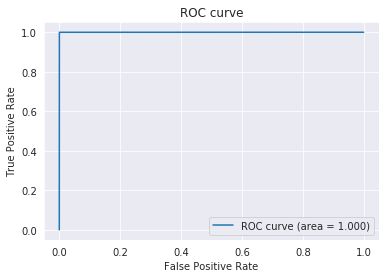

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

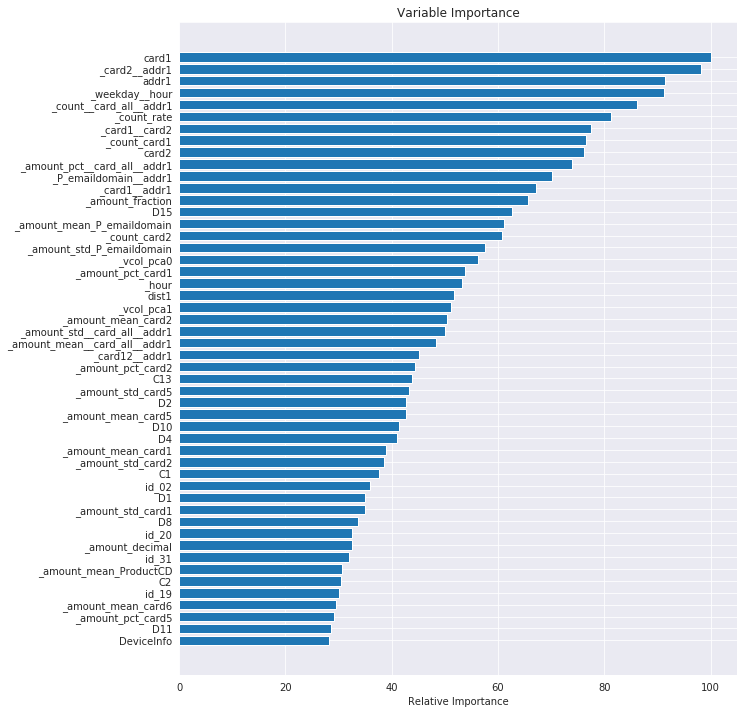

In [14]:
# Plot feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [15]:
submission = pd.DataFrame()
submission['TransactionID'] = X_test_id
submission['isFraud'] = sub_preds
submission.to_csv('submission.csv', index=False)